In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import math
from functools import partial
from sklearn.utils import shuffle



In [2]:
data_chips = pd.read_csv("data/chips.csv")
data_geyser = pd.read_csv("data/geyser.csv")
data_chips.describe()

,x,y
count,118.000000,118.000000
mean,0.054779,0.183102
std,0.496654,0.519743
min,-0.830070,-0.769740
25%,-0.372120,-0.254385
50%,-0.006336,0.213455
75%,0.478970,0.646562
max,1.070900,1.108900


In [3]:
def convert(data):
    data['class']= data['class'].replace({'N': -1, 'P': 1})
    return data
def gaussian(x,y,B):
    return math.exp(-B*np.linalg.norm(x-y)**2)
def polynominal(x,y,P):
    return (x@y + 1)**P
def linear(x,y):
    return x@y

In [4]:
data_geyser = convert(data_geyser)
data_chips = convert(data_chips)
data_geyser.head()

,x,y,class
0,1,4.4,-1
1,1,3.9,-1
2,1,4.0,1
3,1,4.0,-1
4,1,3.5,-1


In [5]:
def fit(matrix,c):
    out = open("input","w")
    out.write(str(len(matrix)) + '\n')
    for row in matrix:
        for item in row:
            out.write(str(item) + ' ')
        out.write('\n')
    out.write(str(c))
    out.close()
    subprocess.call("Linear.exe")
    inf = open("output","r")
    ans = [float(inf.readline()) for _ in range(len(matrix)+1)]
    return ans
def predict(l,kernel,X,y,x):
    ans = l[-1]
    for i in range(len(l)-1):
        ans += l[i]*y[i]*kernel(x,X[i])
    return 1 if ans > 0 else -1
def predictMany(l,kernel,X,y,xs):
    res = []
    for x in xs:
        ans = l[-1]
        for i in range(len(l)-1):
            ans += l[i]*y[i]*kernel(x,X[i])
        res.append(1 if ans > 0 else -1)   
    return res
def accuracy(actual, predicted):
    return sum([0 if p!=a else 1 for a,p in zip(actual,predicted)])/len(actual)

In [6]:
def calculateMatrix(X,y, kernel):
    matrix = [[0 for _ in range(len(X)+1)] for _ in range(len(X))]
    for i in range(len(X)):
        for j in range(len(X)):
            matrix[i][j] = kernel(X[i],X[j])
        matrix[i][len(X)] = y[i]
    return matrix

In [7]:
def validation(data,kernel,c):
    data = shuffle(data)
    ksize = math.ceil(len(data) / 5)
    score = 0
    for i in range(5):
        test = data.iloc[ksize*i:min(len(data),ksize*(i+1))]
        train = pd.concat([data.iloc[0:ksize*i],data.iloc[ksize*(i+1):len(data)]])
        
        XTrain = np.asarray(train.drop('class',axis=True))
        YTrain = np.asarray(train['class'])
        
        XTest = np.asarray(test.drop('class',axis=True))
        YTest = np.asarray(test['class'])
        M = calculateMatrix(XTrain,YTrain,kernel)
        l = fit(calculateMatrix(XTrain,YTrain,kernel),c)
        YTestPredicted = [predict(l,kernel,XTrain,YTrain,x) for x in XTest]
        score += accuracy(YTestPredicted,YTest)
    return score/5
        

In [8]:
polynomic = [partial(polynominal,P=x) for x in [2,3,4,5]]
gaussians = [partial(gaussian,B=x) for x in [1,2,3,4,5]]
kernels = [linear] + polynomic + gaussians
groups_kernel = {'linear' : [linear], 'gaussian' : gaussians, 'polynomic': polynomic}
C = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

In [9]:
def parameteters_search(data):
    best_kernels = {}
    for group in groups_kernel:
        best_kernel_in_group = None
        local_c = 0
        local_score = 0
        for kernel in groups_kernel[group]:
            for c in C:
                ac = validation(data,kernel,c)
                if(ac > local_score):
                    local_score = ac
                    local_c = c
                    best_kernel_in_group = kernel
        best_kernels[group] = (best_kernel_in_group,local_c)
        print(kernel, local_c, local_score)
    return best_kernels

In [10]:
kernels_chips = parameteters_search(data_chips)

<function linear at 0x000001DB9D97EB70> 5.0 0.5265151515151516
functools.partial(<function gaussian at 0x000001DB9D97EA60>, B=5) 5.0 0.8295454545454545
functools.partial(<function polynominal at 0x000001DB9D97EAE8>, P=5) 50.0 0.8462121212121213


In [11]:
kernels_gesers = parameteters_search(data_geyser)

<function linear at 0x000001DB9D97EB70> 0.5 0.900952380952381


KeyboardInterrupt: 

In [13]:
fit(calculateMatrix?)

SyntaxError: invalid syntax (<ipython-input-13-8fce138176a9>, line 1)

In [19]:
def draw_plots(data,kernels,h=0.05):
    x_min, x_max = data['x'].min() - 0.5, data['x'].max() + 0.5
    y_min, y_max = data['y'].min() - 0.5, data['y'].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    X = np.asarray(data.drop('class',axis=True))
    Y = np.asarray(data['class'])
    for group in groups_kernel:
        l = fit(calculateMatrix(X,Y,kernels[group][0]),kernels[group][1])
        Z=predictMany(l,kernels[group][0],X,Y,np.c_[xx.ravel(), yy.ravel()])
        Z=np.asarray(Z).reshape(xx.shape)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        plt.scatter(data['x'], data['y'], c=data['class'], cmap=plt.cm.coolwarm)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title(group)
        plt.show()

    

    

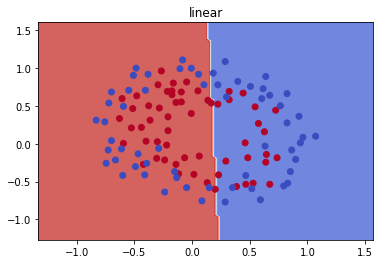

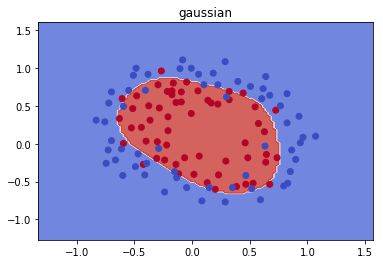

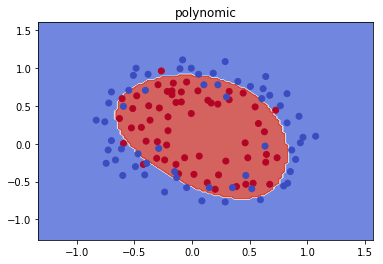

In [20]:
draw_plots(data_chips,kernels_chips,h=0.025)

In [ ]:
draw_plots(data_geyser, kernels_gesers,h=0.1)

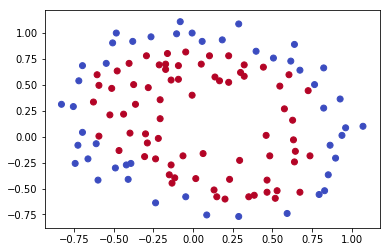

0.8559322033898306


In [18]:
XG = np.asarray(data_chips.drop('class',axis=True))
YG = np.asarray(data_chips['class'])
kernelG = partial(polynominal,P=5)
l = fit(matrix=calculateMatrix(XG,YG,kernel=partial(polynominal,P=5)),c=5)
predicted = predictMany(l,kernelG,XG,YG,XG)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.scatter(data_chips['x'], data_chips['y'], c=predicted, cmap=plt.cm.coolwarm)
plt.show()
print(accuracy(YG,predicted))

In [23]:
np.meshgrid(np.arange(1, 5, 0.25), np.arange(1, 5, 0.25))

[array([[1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
         3.75, 4.  , 4.25, 4.5 , 4.75],
        [1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
         3.75, 4.  , 4.25, 4.5 , 4.75],
        [1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
         3.75, 4.  , 4.25, 4.5 , 4.75],
        [1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
         3.75, 4.  , 4.25, 4.5 , 4.75],
        [1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
         3.75, 4.  , 4.25, 4.5 , 4.75],
        [1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
         3.75, 4.  , 4.25, 4.5 , 4.75],
        [1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
         3.75, 4.  , 4.25, 4.5 , 4.75],
        [1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
         3.75, 4.  , 4.25, 4.5 , 4.75],
        [1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
     